# Test Numerical Covariance Procedure

In [78]:
from py21cmmc_wv.likelihood import LikelihoodWaveletsMorlet
from py21cmmc.mcmc.mcmc import build_computation_chain
from py21cmmc.mcmc.core import CoreLightConeModule
import numpy as np
from numpy.linalg import slogdet

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm

from py21cmmc_wv import util

In [2]:
lk = LikelihoodWaveletsMorlet(nrealisations=10)
core = CoreLightConeModule(redshift=7.0, max_redshift=7.5)

chain = build_computation_chain(core, lk)

UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)
UserParams(BOX_LEN:150.0, DIM:200, HII_DIM:50)


In [3]:
lk.covariance[0,10]

1192230470906.0479

In [22]:
lk.covariance[:lk.n_frequency,:lk.n_frequency]

<57x57 sparse matrix of type '<class 'numpy.float64'>'
	with 900 stored elements in Compressed Sparse Column format>

In [24]:
lk.covariance

<6384x6384 sparse matrix of type '<class 'numpy.float64'>'
	with 61635 stored elements in Compressed Sparse Column format>

In [26]:
6384**2 * 8 / 1024/1024/1024

0.3036518096923828

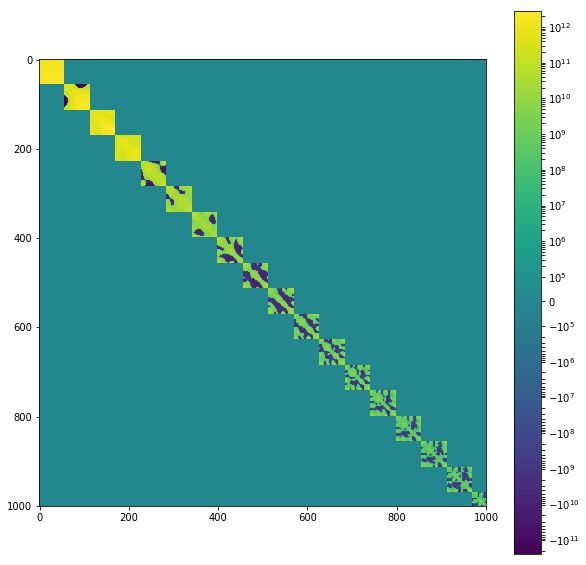

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(lk.covariance.toarray()[:1000,:1000], norm=SymLogNorm(linthresh=1e5))
plt.colorbar()

In [52]:
lk.computeLikelihood(lk.default_ctx, {})

-7.815709654483038e+20

### Test Block-Diag Solvers

In [41]:
x = np.linspace(0,1,10)
y = np.cov(np.random.normal(size=(10, 100)))
X = np.repeat(x,10)
Y = np.zeros((100, 100))
for i in range(10):
    Y[i*10:(i+1)*10, i*10:(i+1)*10] = y
    

In [38]:
np.linalg.slogdet(Y)

(1.0, -13.500454413556714)

In [40]:
util.logdet_block_matrix(Y, 10)

-13.500454413556714

In [43]:
np.linalg.solve(Y,X).T.dot(X)

36.490563510730766

In [48]:
util.solve_block_matrix(Y,X,10).T.dot(X)

36.490563510730766

In [30]:
np.sum([slogdet(lk.covariance[i*lk.n_frequency:(i+1)*lk.n_frequency, i*lk.n_frequency:(i+1)*lk.n_frequency].toarray())[1] for i in range(int(lk.covariance.shape[0]/lk.n_frequency))])

-70801.30500048216

In [16]:
logdet_chol(lk.covariance)

nan

In [28]:
cov = lk.covariance.toarray()

In [29]:
cov.max()

1.5419764230904953e-17

In [30]:
cov.min()

-1.5419764230904953e-17

In [35]:
np.sum(cov==0)/cov.size

0.9984876871454953

In [36]:
del cov

In [37]:
wvlt = []
for i in range(10):
    wvlt.append(lk.simulate(lk.default_ctx)['wavelets'])
wvlt = np.array(wvlt)

In [38]:
wvlt.shape

(10, 4, 57, 28)

In [42]:
covs = [np.cov(x) for x in wvlt.transpose((1,3,2,0)).reshape((-1, lk.n_frequency, lk.nrealisations))]

In [43]:
covs

[array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  3.85494106e-18, -3.85494106e-18],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -3.85494106e-18,  3.85494106e-18]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.0000

In [46]:
np.all(wvlt[0] == wvlt[1])

True

# Test Model Covariance

In [26]:
from py21cmmc import run_lightcone
from py21cmmc_wv.morlet import morlet_transform_c
from powerbox.dft import fft
import numpy as np

In [3]:
lc = run_lightcone(redshift=7.0, max_redshift=10.0, user_params={"HII_DIM":100})

In [55]:
mean_power = 0
nu = np.linspace(0,10,100)
dnu = nu[1] - nu[0]
var = 100
mean_nonfourier = 0


for i in range(1000):
    fake_visibility = np.random.normal(0, np.sqrt(var/2), size=100) + 1j * np.random.normal(0, np.sqrt(var/2), size=100)
    fvis, eta, nu = morlet_transform_c(fake_visibility, nu)
    
    mean_power += np.outer(fvis[:,-10], np.conj(fvis[:,-10]))/1000
    mean_nonfourier += np.mean(np.abs(fake_visibility)**2) / 1000

In [56]:
mean_nonfourier # should just be the var.

99.99222980696382

In [11]:
fvis.shape

(100, 49)

In [33]:
expected_mean_power = var * dnu**2 * np.sum()
expected_mean_power = expected_mean_power.reshape((100, 100, -1))

TypeError: sum() missing 1 required positional argument: 'a'

In [68]:
expected_mean_power_var = var * dnu * np.sqrt(np.pi) / eta
expected_mean_power_cov = (expected_mean_power_var  * np.exp(-np.outer(eta**2, np.add.outer(nu,-nu)**2) / 4).T).T.reshape((len(eta), len(nu), len(nu)))

In [70]:
expected_mean_power_var[-10], expected_mean_power_cov[-10, 49, 49]

(4.521104608982541, 4.521104608982541)

In [65]:
mean_power[49,49]

(4.452418852294267+0j)

In [76]:
expected_mean_power_cov[-10, 52, 44], np.abs(mean_power[52, 44])

(0.3495028183144017, 0.392098656662472)

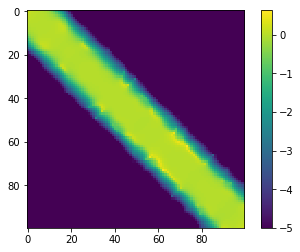

In [82]:
plt.imshow(np.log10(expected_mean_power_cov[-10]/np.abs(mean_power)), vmin=-5)
plt.colorbar()

In [37]:
expected_mean_power = var * 2*np.pi / np.e / eta #np.exp(-np.outer(eta**2,np.add.outer(nu,-nu)**2)/4).T

In [51]:
np.abs(mean_power).max()

4.851183142724527

In [52]:
expected_mean_power[-10]

58.370068171258666

In [29]:
mean_power

array([[0.1157088 , 0.14946205, 0.14790399, ..., 0.08052177, 0.07190882,
        0.0533229 ],
       [0.14946205, 0.20390368, 0.21462834, ..., 0.11048008, 0.09836039,
        0.07264401],
       [0.14790399, 0.21462834, 0.24680592, ..., 0.12600982, 0.11146731,
        0.08175361],
       ...,
       [0.08052177, 0.11048008, 0.12600982, ..., 0.22922492, 0.19400801,
        0.12936967],
       [0.07190882, 0.09836039, 0.11146731, ..., 0.19400801, 0.1801733 ,
        0.12915763],
       [0.0533229 , 0.07264401, 0.08175361, ..., 0.12936967, 0.12915763,
        0.09899728]])

mathematical working

\begin{equation}
    \langle P \rangle = \Delta x \sum e^{-k^2/2 (x - x_c)^2} e^{-ik(x-x_c)} V
\end{equation}

Taking covariance:
\begin{equation}
    {\rm Cov}(V,V') = \sum \Delta x \Delta x e^{-k^2/2 [(x - x_c)^2 + (x' - x_c')^2]} {\rm Var}(V).
\end{equation}

\begin{equation}
    {\rm Cov}(V,V') = {\rm Var}(V) \int dx e^{-k^2 (x - x_c)^2}
\end{equation}

\begin{equation}
    \Delta \nu {\rm Var}(V) \sqrt{\pi}/k.
\end{equation}


